In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import math
from scipy.interpolate import interp1d
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.mlab import griddata

### Fixed Parameters

In [3]:
Data=pd.read_csv("cases_durations.csv",sep = ',', header = 0)

In [4]:
β = 0.005
μ1 = 1/21 #14 days infectious
μ2 = 1/5 #5 days (14 - 9 days)
σ =1/5 #5 days exposed
ω=1/9 # 9 days until emitted to hospital
ϵ = 0.0001
α = 1/2
pp = 0.7
capT = 10000
γ = 1/(80*365)
Input_H = [1500,1,0,0,0]
Nn = sum(Input_H)

# SEIHR with fixed rates without external infection

In [6]:
def gillespieSEIHR(initial, beta, mu1,mu2, sigma, omega,epsilon,alpha, mort, gam,  max_time):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    cuminf = []
    cuminf.append(0)
    events = []
    while times <max_time and (pop[ind][1]+pop[ind][2]+pop[ind][3]>0):
        state = np.zeros(shape= (5,12))
        
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################
        
        
        R_se = beta*(pop[ind][0])*(pop[ind][2] + alpha*pop[ind][3])/N + epsilon*pop[ind][0] 
        state[:,0] = [-1, 1, 0, 0,0]
        
        R_ei = sigma*pop[ind][1]
        state[:,1] = [0, -1, 1, 0,0]
        
        R_ih = omega*pop[ind][2]
        state[:,2] = [0, 0, -1, 1, 0]
        
        R_ir = mort*mu1*pop[ind][2]
        state[:,3] = [0,0,-1,0,1]
        
        R_hr = mort*mu2*pop[ind][3]
        state[:,4] = [0,0,0,-1,1]

        R_is = (1-mort)*mu1*pop[ind][2]
        state[:,5] = [1,0,-1,0,0]

        R_hs = (1-mort)*mu2*pop[ind][3]
        state[:,6] = [1,0,0,-1,0]
        

        rate = [R_se, R_ei, R_ih, R_ir, R_hr, R_is, R_hs]

        Rtotal = sum(rate)
        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        times =times+ delta_t
        event = np.min(np.where(P<=np.cumsum(rate)))
        events.append(event)
        event_time.append(times)
        pop.append(pop[ind]+state[:,event])
        
        if event == 1:
            cuminf.append(1 +cuminf[ind] )
        else:
            cuminf.append(0 +cuminf[ind])
        ind=ind+1
        N = sum(pop[ind][:5])

    return event_time, np.array(pop), events, cuminf

## ODEs

In [20]:
def dSEIHR_dt(X, tt ):
    return [-β*X[0]*(X[2]+α*X[3])/sum(X[:3]) - ϵ*X[0] + (1-pp)*(μ1*X[2] + μ2*X[3]), 
            β*X[0]*(X[2]+α*X[3])/sum(X[:3]) + ϵ*X[0]- σ*X[1] ,
            σ*X[1] - (μ1+ω)*X[2],
            ω*X[2]-μ2*X[3],
            pp*(μ1*X[2]+μ2*X[3])]

ts = np.linspace(0, capT, 1000)
Nn = sum(Input_H)
P_seihr = odeint(dSEIHR_dt, Input_H, ts)

# Plots

In [25]:
Gh = gillespieSEIHR(Input_H, β, μ1, μ2, σ, ω, ϵ, α,pp, γ, capT)
SEIHRt = Gh[0]
SEIHRs = Gh[1][:,0]
SEIHRe = Gh[1][:,1]
SEIHRi = Gh[1][:,2]
SEIHRh = Gh[1][:,3]
SEIHRr = Gh[1][:,4]

In [27]:
manhe = []
manht = []
manhh = []
manhi = []
for ind, x in enumerate(SEIHRt):
    if ind<len(SEIHRt)-1:
        manhe.append((SEIHRe[ind], SEIHRe[ind]))
        manhh.append((SEIHRh[ind], SEIHRh[ind]))
        manhi.append((SEIHRi[ind], SEIHRi[ind]))
        manht.append((SEIHRt[ind], SEIHRt[ind+1]))
manhe = np.array(manhe).flatten()
manht = np.array(manht).flatten()
manhh = np.array(manhh).flatten()
manhi = np.array(manhi).flatten()

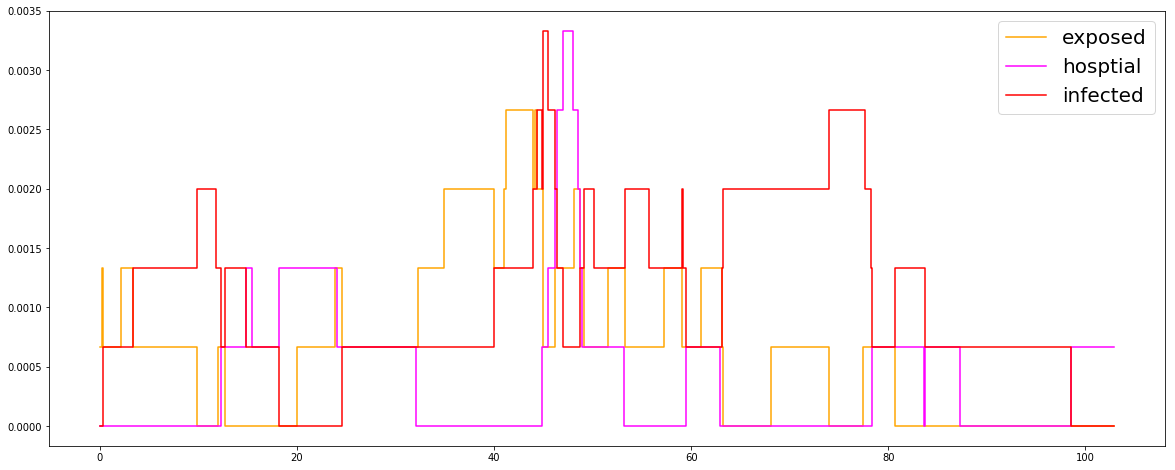

In [28]:
plt.figure(figsize = (20,8))
plt.plot(manht, manhe/Nn,c='orange', label = 'exposed')
plt.plot(manht, manhh/Nn,c='magenta', label = 'hosptial')

plt.plot(manht,manhi/Nn,c= 'r', label = 'infected')
plt.legend(fontsize = 20)

## Multiple simulations

In [331]:
Time = []
Inf = []
Exp = []
Hos = []
Cum = []
Num_sim = 100
for i in range(Num_sim):
    Gh_adj = gillespieSEIHR(Input_H, β, μ1, μ2, σ, ω, ϵ, α,pp, γ, capT)
    SEIHRt_adj = Gh_adj[0]
    SEIHRs_adj = Gh_adj[1][:,0]
    SEIHRe_adj = Gh_adj[1][:,1]
    SEIHRi_adj = Gh_adj[1][:,2]
    SEIHRh_adj = Gh_adj[1][:,3]
    SEIHRr_adj = Gh_adj[1][:,4]
    manhe = []
    manht = []
    manhh = []
    manhi = []
    cum_inf = []
    for ind, x in enumerate(SEIHRt_adj):
        if ind<len(SEIHRt_adj)-1:
            manhe.append((SEIHRe_adj[ind], SEIHRe_adj[ind]))
            manhh.append((SEIHRh_adj[ind], SEIHRh_adj[ind]))
            manhi.append((SEIHRi_adj[ind], SEIHRi_adj[ind]))
            manht.append((SEIHRt_adj[ind], SEIHRt_adj[ind+1]))
            cum_inf.append((np.cumsum(np.array(Gh_adj[2]) == 1)[ind], np.cumsum(np.array(Gh_adj[2]) == 1)[ind])) 
    Time.append(np.array(manht).flatten())
    Inf.append(np.array(manhi).flatten())
    Exp.append(np.array(manhe).flatten())
    Hos.append(np.array(manhh).flatten())
    Cum.append(np.array(cum_inf).flatten())

In [333]:
max_time = []
num_inf = []
for k in range(i):
    max_time.append(max(Time[k]))
    num_inf.append(Cum[k][-1])
    
totalT = math.ceil(max(max_time))
inter_t = np.arange(0, totalT , 0.5)

# Compare observed outbreak summary results with simulations

Chosen for suitable parameters

Text(0,0.5,'Duration')

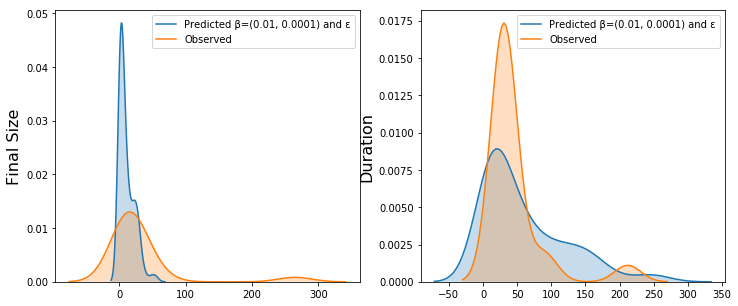

In [336]:
plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
sns.kdeplot(num_inf, shade = True, label = 'Predicted β={} and ɛ'.format((β, ϵ)))
sns.kdeplot(Data['Total Cases'], shade = True, label = 'Observed')
plt.ylabel('Final Size', fontsize = 16)
plt.subplot(1,2,2)
sns.kdeplot(max_time, shade = True, label = 'Predicted β={} and ɛ'.format((β, ϵ)))
sns.kdeplot(Data['Duration'], shade = True, label = 'Observed')

plt.ylabel('Duration', fontsize =16)


In [16]:
inter_i = []
inter_e = []
inter_h = []
inter_cum = []
for l in range(Num_sim):
    inter_i.append(np.interp(inter_t, Time[l], Inf[l], right = 0))
    inter_e.append(np.interp(inter_t, Time[l], Exp[l], right = 0))
    inter_h.append(np.interp(inter_t, Time[l], Hos[l], right = 0))
    inter_cum.append(np.interp(inter_t, Time[l], Cum[l]))

Text(0.5,1,'Cumulative Infections')

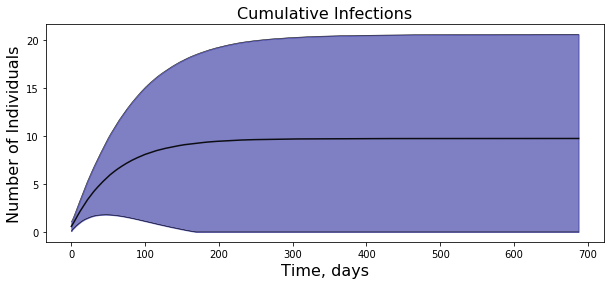

In [17]:
plt.figure(figsize = (10,4))
plt.plot(inter_t, np.mean(inter_cum, axis = 0),'-', color ='k', alpha = 0.9)
plt.plot(inter_t, (np.mean(inter_cum, axis = 0)+np.std(inter_cum, axis = 0)), color ='k', lw=0.5)
plt.plot(inter_t, np.maximum((np.mean(inter_cum, axis = 0)-np.std(inter_cum, axis = 0)),0),color ='k', lw=0.5)
plt.fill_between(inter_t, (np.mean(inter_cum, axis = 0)+np.std(inter_cum, axis = 0)), np.maximum((np.mean(inter_cum, axis = 0)-np.std(inter_cum, axis = 0)),0), 1, alpha=0.5, color = 'darkblue')
# plt.ylim([0,20])
plt.ylabel('Number of Individuals', fontsize = 16)
plt.xlabel('Time, days', fontsize = 16)
plt.title('Cumulative Infections', fontsize = 16)

(0, 100)

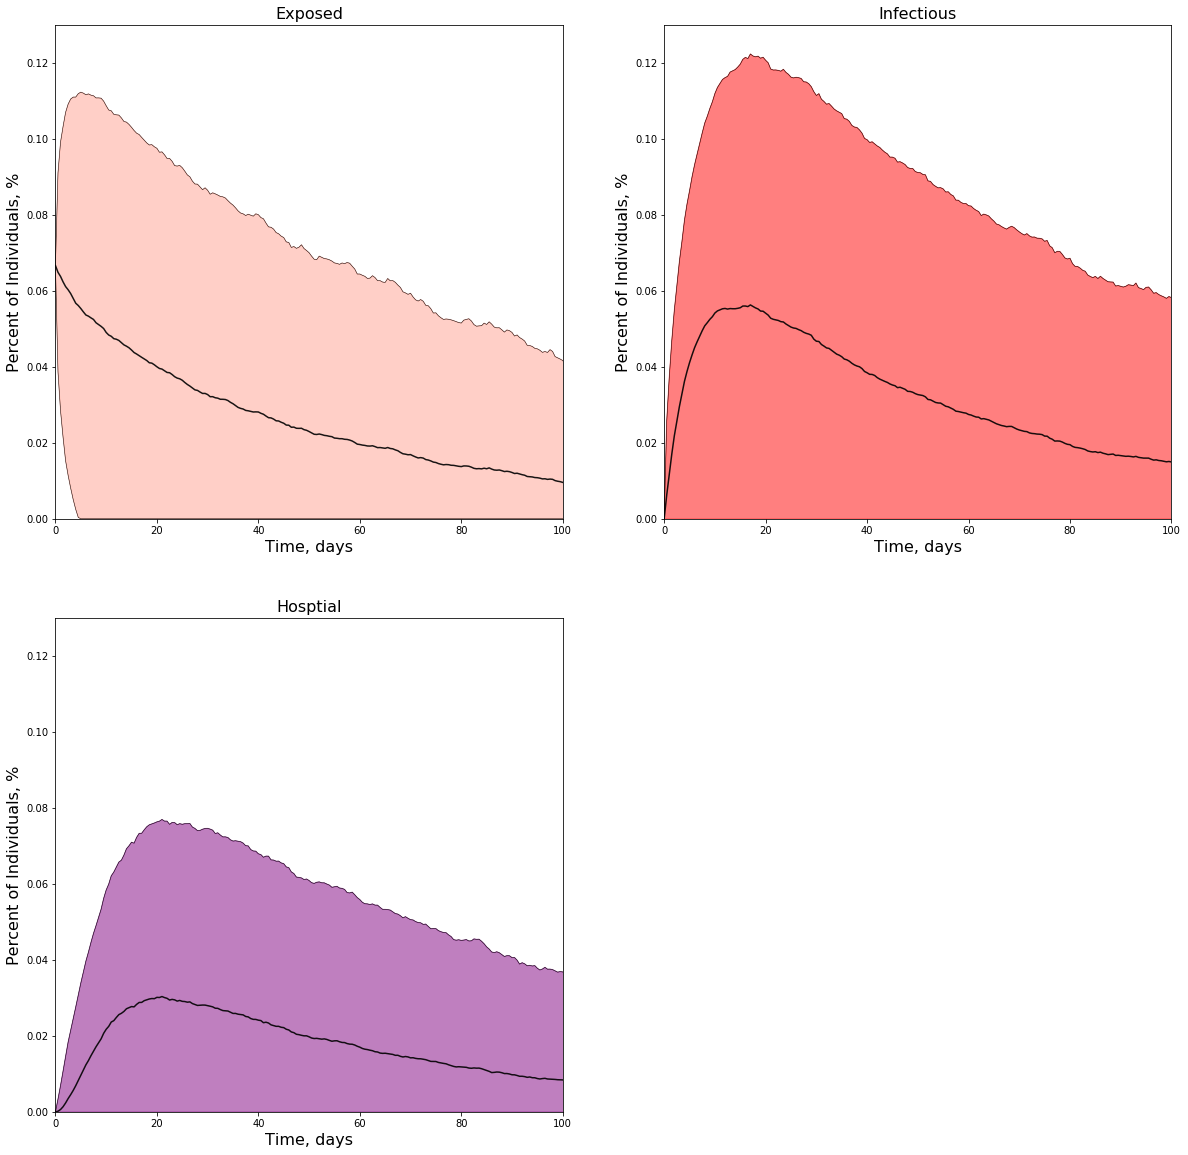

In [223]:
plt.figure(figsize = (20,20))
plt.subplot(2,2,1)
plt.plot(inter_t, 100*np.mean(inter_e, axis = 0)/Nn,'-', color ='k', alpha = 0.9)
plt.plot(inter_t, 100*(np.mean(inter_e, axis = 0)+np.std(inter_e, axis = 0))/Nn, color ='k', lw=0.5)
# plt.plot(inter_t, 100*inter_e[5]/Nn, '--', color = 'grey')
plt.plot(inter_t, 100*np.maximum((np.mean(inter_e, axis = 0)-np.std(inter_e, axis = 0))/Nn,0),color ='k', lw=0.5)
plt.fill_between(inter_t,  100*(np.mean(inter_e, axis = 0)+np.std(inter_e, axis = 0))/Nn, 100*np.maximum((np.mean(inter_e, axis = 0)-np.std(inter_e, axis = 0))/Nn,0), 1, alpha=0.3, color = 'tomato')
plt.ylim([0,0.13])
plt.ylabel('Percent of Individuals, %', fontsize = 16)
plt.xlabel('Time, days', fontsize = 16)
plt.title('Exposed', fontsize = 16)
plt.xlim([0,100])

plt.subplot(2,2,2)
plt.plot(inter_t, 100*np.mean(inter_i, axis = 0)/Nn,'-', color ='k', alpha = 0.9)
plt.plot(inter_t, 100*(np.mean(inter_i, axis = 0)+np.std(inter_i, axis = 0))/Nn, color ='k', lw=0.5)
plt.plot(inter_t, 100*np.maximum((np.mean(inter_i, axis = 0)-np.std(inter_i, axis = 0))/Nn,0),color ='k', lw=0.5)
plt.fill_between(inter_t,  100*(np.mean(inter_i, axis = 0)+np.std(inter_i, axis = 0))/Nn, 100*np.maximum((np.mean(inter_i, axis = 0)-np.std(inter_i, axis = 0))/Nn,0), 1, alpha=0.5, color = 'red')
plt.ylim([0,0.13])
plt.ylabel('Percent of Individuals, %', fontsize = 16)
plt.xlabel('Time, days', fontsize = 16)
plt.title('Infectious', fontsize = 16)
plt.xlim([0,100])

plt.subplot(2,2,3)
plt.plot(inter_t, 100*np.mean(inter_h, axis = 0)/Nn,'-', color ='k', alpha = 0.9)
plt.plot(inter_t, 100*(np.mean(inter_h, axis = 0)+np.std(inter_h, axis = 0))/Nn, color ='k', lw=0.5)
plt.plot(inter_t, 100*np.maximum((np.mean(inter_h, axis = 0)-np.std(inter_h, axis = 0))/Nn,0),color ='k', lw=0.5)
plt.fill_between(inter_t,  100*(np.mean(inter_h, axis = 0)+np.std(inter_h, axis = 0))/Nn, 100*np.maximum((np.mean(inter_h, axis = 0)-np.std(inter_h, axis = 0))/Nn,0), 1, alpha=0.5, color = 'purple')
plt.ylim([0,0.13])
plt.ylabel('Percent of Individuals, %', fontsize = 16)
plt.xlabel('Time, days', fontsize = 16)
plt.title('Hosptial', fontsize = 16)
plt.xlim([0,100])


## Heatmaps to determine order of $\beta$ and $\varepsilon$

In [9]:
import time
betas1 = np.linspace(0,0.01, 100)
eps1 = np.linspace(0,0.005, 100)
betas = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
eps = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10]
Num_param = len(betas)


In [186]:
final = np.zeros(shape = (Num_param,Num_param))
duration = np.zeros(shape = (Num_param,Num_param))

for k in range(Num_param):
    for y in range(Num_param):
        start = time.time()
        B = betas[k]
        E = eps[y]
        Time = []
        Cum = []
        Num_sim = 100
        for i in range(Num_sim):
            Gh_adj = gillespieSEIHR(Input_H, B, μ1, μ2, σ, ω, E, α,pp, γ, capT)
            SEIHRt_adj = Gh_adj[0]
            manht = []
            for ind, x in enumerate(SEIHRt_adj):
                if ind<len(SEIHRt_adj)-1:
                    manht.append((SEIHRt_adj[ind], SEIHRt_adj[ind+1]))
            Time.append(np.array(manht).flatten())
            Cum.append(sum(np.array(Gh_adj[2])==1))
        total_time = []
        for j in range(Num_sim):
            total_time.append(max(Time[j]))

        final[k,y] = np.mean(Cum)
        duration[k,y] = np.mean(total_time)


In [6]:
b = np.loadtxt('order_final_size.txt')
a = np.loadtxt('order_duration.txt')


Text(51,0.5,'β')

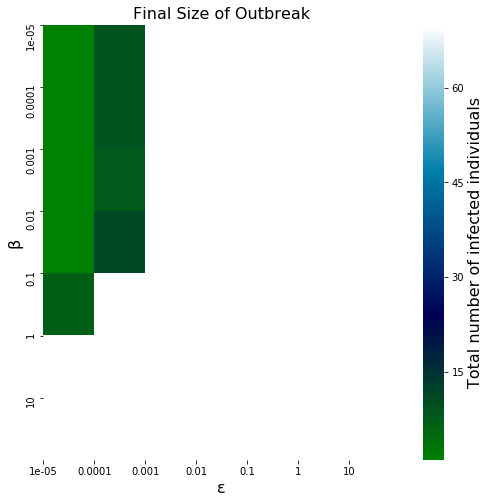

In [18]:
pcm = sns.heatmap(b,  cmap= 'ocean', vmax = 70, cbar_kws={'label': 'Total number of infected individuals'}) # you don't need rasterized=True
pcm.figure.axes[-1].yaxis.label.set_size(16)

plt.title('Final Size of Outbreak', fontsize = 16)
plt.xticks(np.arange(7),betas)
plt.yticks(np.arange(7), eps)
plt.xlabel('ɛ', fontsize = 16)
plt.ylabel('β', fontsize = 16)


# Gillespie with step function to model seasonality in ɛ -- SEIR and SEIHR

In [4]:
β = 0.005
μ1 = 1/10 #14 days infectious
μ2 = 1/5 #5 days (14 - 9 days)
σ =1/5 #5 days exposed
ω=1/9 # 9 days until emitted to hospital
ϵ = 0.0001
α = 1/2
pp = 0.7
capT = 10000
γ = 1/(80*365)
Input_H = [1500,1,0,0,0]

In [5]:
def gillespieSEIR_season(initial, beta, mu1,mu2, sigma, omega,epsilon,alpha, mort, gam,  max_time):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    year = 1
    cuminf = []
    cuminf.append(0)
    events = []
    while times <max_time:
        state = np.zeros(shape= (4,12))
        
        ############################### Seasonality #######################################
        if np.round(times)%365 <= 120:
            E = epsilon
        else:
            E = 0
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################    
        
        
        R_se = beta*(pop[ind][0])*(pop[ind][2])/N + E*pop[ind][0] 
        state[:,0] = [-1, 1, 0, 0]
        
        R_ei = sigma*pop[ind][1]
        state[:,1] = [0, -1, 1, 0]

        R_ir = mu2*pop[ind][2]
        state[:,2] = [0,0,-1,1]
        

        R_is = mu1*pop[ind][2]
        state[:,3] = [1,0,-1,0]
        
        R_sb = sum(initial[:3])*gam
        state[:,4] = [1, 0, 0, 0]
        
        R_sd = gam*pop[ind][0]
        state[:,5] = [-1, 0, 0, 0]
        
        R_ed = gam*pop[ind][1]
        state[:,6] = [0,-1,0,0]
        
        R_id = gam*pop[ind][2]
        state[:,7] = [0, 0, -1, 0]
        

########################## RATES ##############################
        rate = [R_se, R_ei,  R_ir,  R_is, R_sb, R_sd, R_ed, R_id]

        Rtotal = sum(rate)

        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        
        if Rtotal>0:
            times =times+ delta_t
            event = np.min(np.where(P<=np.cumsum(rate)))
            events.append(event)
            event_time.append(times)
            pop.append(pop[ind]+state[:,event])
        else:
            times = year*365
            year = year +1 
            events.append(-1)
            event_time.append(times)
            pop.append(pop[ind])
        if event == 1:
            cuminf.append(1 +cuminf[ind] )
        else:
            cuminf.append(0 +cuminf[ind])
        ind=ind+1
        N = sum(pop[ind][:5])

    return event_time, np.array(pop), events

In [87]:
def gillespieSEIHR_season(initial, beta, mu1,mu2, sigma, omega,epsilon,alpha, mort, gam,  max_time):
    event_time = []
    pop = []
    N = sum(initial)
    pop.append(initial)
    event_time.append(0)
    times = 0
    ind = 0
    year = 1
    cuminf = []
    cuminf.append(0)
    events = []
    while times <max_time:
        state = np.zeros(shape= (5,12))
        
        ############################### Seasonality #######################################
        if np.round(times)%365 <= 120:
            E = epsilon
        else:
            E = 0
        ####################################################################################
        #################################### EVENTS ########################################
        ####################################################################################    
        
        
        R_se = beta*(pop[ind][0])*(pop[ind][2] + alpha*pop[ind][3])/N + E*pop[ind][0] 
        state[:,0] = [-1, 1, 0, 0,0]
        
        R_ei = sigma*pop[ind][1]
        state[:,1] = [0, -1, 1, 0,0]
        
        R_ih = omega*pop[ind][2]
        state[:,2] = [0, 0, -1, 1, 0]
        
        R_ir = mort*mu1*pop[ind][2]
        state[:,3] = [0,0,-1,0,1]
        
        R_hr = mort*mu2*pop[ind][3]
        state[:,4] = [0,0,0,-1,1]

        R_is = (1-mort)*mu1*pop[ind][2]
        state[:,5] = [1,0,-1,0,0]
        
        R_hs = (1-mort)*mu2*pop[ind][3]
        state[:,6] = [1,0,0,-1,0]
        
########################## RATES ##############################
        rate = [R_se, R_ei, R_ih, R_ir, R_hr, R_is, R_hs]

        Rtotal = sum(rate)

        delta_t= -np.log(np.random.uniform(0,1))/Rtotal
        P = np.random.uniform(0,1)*Rtotal
        
        if Rtotal>0:
            times =times+ delta_t
            event = np.min(np.where(P<=np.cumsum(rate)))
            events.append(event)
            event_time.append(times)
            pop.append(pop[ind]+state[:,event])
        else:
            times = year*365
            year = year +1 
            events.append(-1)
            event_time.append(times)
            pop.append(pop[ind])
        if event == 1:
            cuminf.append(1 )
        else:
            cuminf.append(0)
        ind=ind+1
        N = sum(pop[ind][:5])

    return event_time, np.array(pop), events

In [6]:
Input_H = [1500, 1, 0, 0]
Gh_season = gillespieSEIR_season(Input_H, β, μ1, μ2, σ, ω, ϵ, α,pp, γ, capT)
SEIHRt_s = Gh_season[0]
SEIHRs_s = Gh_season[1][:,0]
SEIHRe_s = Gh_season[1][:,1]
SEIHRi_s = Gh_season[1][:,2]
SEIHRr_s = Gh_season[1][:,3]

In [7]:
manhes = []
manhts = []
manhhs = []
manhis = []
manhss = []
manhrs = []
for ind, x in enumerate(SEIHRt_s):
    if ind<len(SEIHRt_s)-1:
        manhes.append((SEIHRe_s[ind], SEIHRe_s[ind]))
        manhis.append((SEIHRi_s[ind], SEIHRi_s[ind]))
        manhss.append((SEIHRs_s[ind], SEIHRs_s[ind]))
        manhrs.append((SEIHRr_s[ind], SEIHRr_s[ind]))
        manhts.append((SEIHRt_s[ind], SEIHRt_s[ind+1]))
manhes = np.array(manhes).flatten()
manhts = np.array(manhts).flatten()
manhss = np.array(manhss).flatten()
manhrs = np.array(manhrs).flatten()
manhis = np.array(manhis).flatten()

(360, 500)

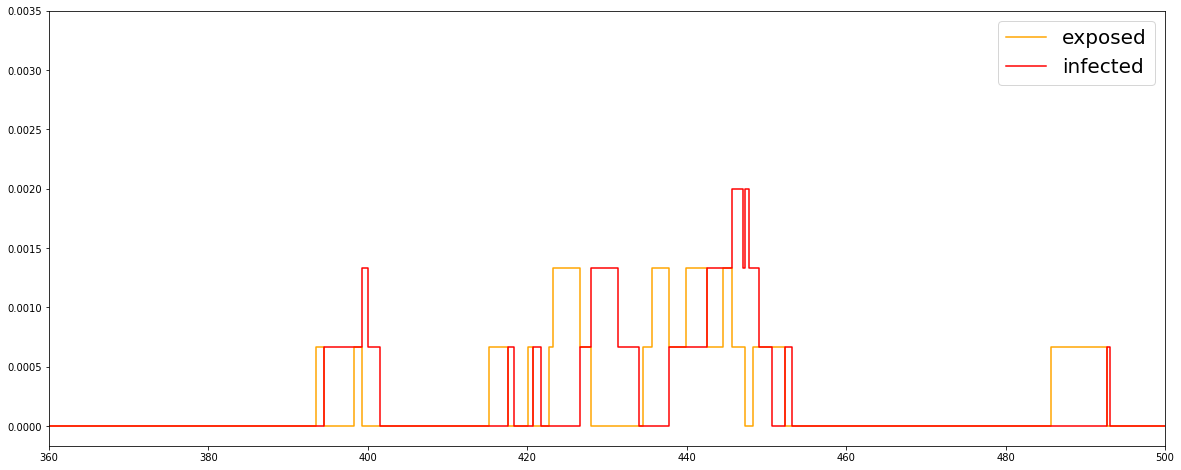

In [18]:
plt.figure(figsize = (20,8))
plt.plot(manhts, manhes/Nn,c='orange', label = 'exposed')

plt.plot(manhts,manhis/Nn,c= 'r', label = 'infected')
plt.legend(fontsize = 20)
plt.xlim([360,500])